2023-03-23 13:37:32.521952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-23 13:37:32.634728: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-23 13:37:33.209586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda/lib64
2023-03-23 13:37:33.209685: W tensorfl

Found 8189 files belonging to 1 classes.


2023-03-23 13:37:33.942153: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 13:37:33.949925: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 13:37:33.950587: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-23 13:37:33.951615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use tf.identity instead.


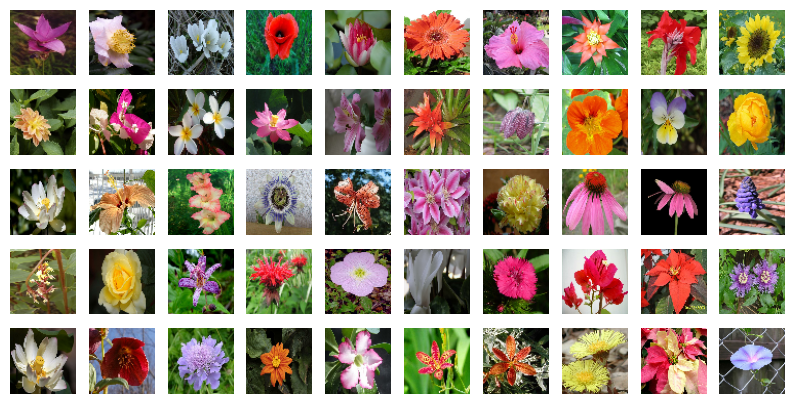

In [1]:
#需要tf2
import tensorflow as tf

data = tf.keras.utils.image_dataset_from_directory(
    '../datas/102flowers',
    labels=None,
    image_size=(64, 64),
    batch_size=None,
    shuffle=True,
    seed=42,
    interpolation='bilinear',
)

data = data.map(lambda x: x / 255).repeat(5).batch(64, drop_remainder=True)


def show(images):
    from matplotlib import pyplot as plt

    if isinstance(images, tf.Tensor):
        images = images.cpu().numpy()

    images = images[:50]

    plt.figure(figsize=(10, 5))

    for i in range(len(images)):
        image = images[i]

        plt.subplot(5, 10, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()


show(next(iter(data)))

In [2]:
def schedule(times, method='offset_cosine'):
    if method == 'linear':
        a = 1 - (1e-4 + times * (0.02 - 1e-4))
        a = tf.math.cumprod(a)
        return tf.sqrt(1 - a), tf.sqrt(a)

    if method == 'cosine':
        #1.5707963267948966 = pi/2
        a = times * 1.5707963267948966
        return tf.sin(a), tf.cos(a)

    if method == 'offset_cosine':
        #0.3175604292915215 = acos(0.95)
        #1.2332345639299847 = acos(0.02) - acos(0.95)
        diffusion_angles = 0.3175604292915215 + times * 1.2332345639299847

        return tf.sin(diffusion_angles), tf.cos(diffusion_angles)


times = tf.convert_to_tensor([x / 20 for x in range(20)])
print('linear=', schedule(times, 'linear'))
print('cosine=', schedule(times, 'cosine'))
print('offset_cosine=', schedule(times, 'offset_cosine'))

linear= (<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.01000083, 0.03456724, 0.05729195, 0.07973238, 0.10203589,
       0.1242316 , 0.14632091, 0.16829596, 0.19014527, 0.2118557 ,
       0.23341325, 0.25480375, 0.27601326, 0.29702735, 0.31783238,
       0.3384149 , 0.35876182, 0.37886015, 0.39869785, 0.418263  ],
      dtype=float32)>, <tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.99995   , 0.99940234, 0.9983575 , 0.9968163 , 0.9947807 ,
       0.99225324, 0.9892372 , 0.9857365 , 0.981756  , 0.97730094,
       0.9723776 , 0.9669928 , 0.9611538 , 0.954869  , 0.9481469 ,
       0.940997  , 0.9334291 , 0.9254539 , 0.9170823 , 0.90832597],
      dtype=float32)>)
cosine= (<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.        , 0.0784591 , 0.15643448, 0.23344539, 0.309017  ,
       0.38268346, 0.45399055, 0.52249855, 0.58778524, 0.64944804,
       0.7071068 , 0.760406  , 0.80901706, 0.85264015, 0.8910065 ,
       0.92387956, 0.95105654, 0.9723699 , 0.98768836, 0

In [3]:
def ResidualBlock(width, x):
    residual = x
    if x.shape[3] != width:
        residual = tf.keras.layers.Conv2D(width, kernel_size=1)(x)

    x = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(center=False, scale=False),
        tf.keras.layers.Conv2D(width,
                               kernel_size=3,
                               padding='same',
                               activation=tf.keras.activations.swish),
        tf.keras.layers.Conv2D(width, kernel_size=3, padding='same'),
    ])(x)

    x = tf.keras.layers.Add()([x, residual])

    return x

In [25]:
def get_unet():
    def DownBlock(width, x, skips):
        x = ResidualBlock(width, x)
        skips.append(x)

        x = ResidualBlock(width, x)
        skips.append(x)

        x = tf.keras.layers.AveragePooling2D(pool_size=2)(x)
        return x


    def UpBlock(width, x, skips):
        x = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")(x)

        x = tf.keras.layers.Concatenate()([x, skips.pop()])
        x = ResidualBlock(width, x)

        x = tf.keras.layers.Concatenate()([x, skips.pop()])
        x = ResidualBlock(width, x)

        return x
    input_image = tf.keras.layers.Input(shape=(64, 64, 3))
    input_var = tf.keras.layers.Input(shape=(1, 1, 1))

    def f(x):
        #6.907755278982137 = log(1000)
        #3.141592653589793 = pi
        a = tf.exp(tf.linspace(0.0, 6.907755278982137,
                               16)) * 2 * 3.141592653589793
        a = a * x
        return tf.concat([tf.sin(a), tf.cos(a)], axis=3)

    var = tf.keras.layers.Lambda(f)(input_var)
    var = tf.keras.layers.UpSampling2D(size=64, interpolation='nearest')(var)

    image = tf.keras.layers.Conv2D(32, kernel_size=1)(input_image)

    image = tf.keras.layers.Concatenate()([image, var])
    
    outs = []
    
    image = DownBlock(32, image, outs)
    image = DownBlock(64, image, outs)
    image = DownBlock(96, image, outs)
    
    image = ResidualBlock(128, image)
    image = ResidualBlock(128, image)
    
    
    image = UpBlock(96, image, outs)
    image = UpBlock(64, image, outs)
    image = UpBlock(32, image, outs)

    image = tf.keras.layers.Conv2D(3,
                                   kernel_size=1,
                                   kernel_initializer='zeros')(image)

    unet = tf.keras.models.Model([input_image, input_var], image)

    return unet


unet = get_unet()

unet

In [26]:
class DiffusionModel(tf.keras.models.Model):

    def __init__(self):
        super().__init__()

        self.normalizer = tf.keras.layers.Normalization()
        self.unet = unet

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.unet([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps
        current_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = schedule(
                diffusion_times)
            pred_noises, pred_images = self.denoise(current_images,
                                                    noise_rates,
                                                    signal_rates,
                                                    training=False)
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = schedule(
                next_diffusion_times)
            current_images = next_signal_rates * pred_images + next_noise_rates * pred_noises
        return pred_images

    def generate(self, num_images, diffusion_steps, initial_noise=None):
        if initial_noise is None:
            initial_noise = tf.random.normal(shape=(num_images, 64, 64, 3))
        generated_images = self.reverse_diffusion(initial_noise,
                                                  diffusion_steps)

        generated_images = self.normalizer.mean + generated_images * self.normalizer.variance**0.5
        generated_images = tf.clip_by_value(generated_images, 0.0, 1.0)

        return generated_images

    def train_step(self, images):
        print('images=',images.shape)
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(64, 64, 64, 3))

        diffusion_times = tf.random.uniform(shape=(64, 1, 1, 1),minval=0.0,maxval=1.0)
        noise_rates, signal_rates = schedule(diffusion_times)

        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the unet to separate noisy images to their components
            pred_noises, pred_images = self.denoise(noisy_images,
                                                    noise_rates,
                                                    signal_rates,
                                                    training=True)

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.unet.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.unet.trainable_weights))


        return {m.name: m.result() for m in self.metrics}


ddm = DiffusionModel()
ddm.normalizer.adapt(data)

ddm.compile(
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=1e-3,
                                                     weight_decay=1e-4),
    loss=tf.keras.losses.mean_absolute_error,
)


class Callback(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs=None):
        gen = self.model.generate(num_images=10, diffusion_steps=20)
        show(gen)


ddm.fit(data, epochs=10, callbacks=[Callback()])

Epoch 1/10
images= (64, 64, 64, 3)
images= (64, 64, 64, 3)


KeyboardInterrupt: 